# Assignment 2

**TODO 0**: Put your name here.

Xiang Fu

In [2]:
!pip install nltk
!pip install pptree

In [3]:
import nltk
import pptree
import numpy as np
import math
from tabulate import tabulate

## Part 1: Building a CKY parser

The CKY recognizer you wrote for Lab 4 can only recognize, not parse---it can tell us if an input is parseable given a grammar or not, but it doesn't tell us what the valid parse is. The first part of this assignment is to change the code you wrote for the CKY recognizer so that it can also return the parse trees.

In order to do this, you need to modify the recognizer in the following two ways:

(1) The table entry (things that get appended to each list) for a non-terminal should contain pointers to the table entries that it was derived from (i.e., the right hand side of the relevant CFG rule). Visualization of these pointers can be found in the figure below.

(Note that this is why we used a list to represent each cell in the table, not a set---even for the same nonterminal symbol S, we can have multiple parses! If you used a set to implement the CKY table, you'd need to change this into a list so you can associate multiple entries of the same symbol with different parses.)

(2) The **parser** function now should return a triple (table, recognized, parses) instead of the tuple (table, recognized) as before. **parses** should be a list of valid parses corresponding to each S in the top right corner of the table. This would be an empty list if **recognized** is False.

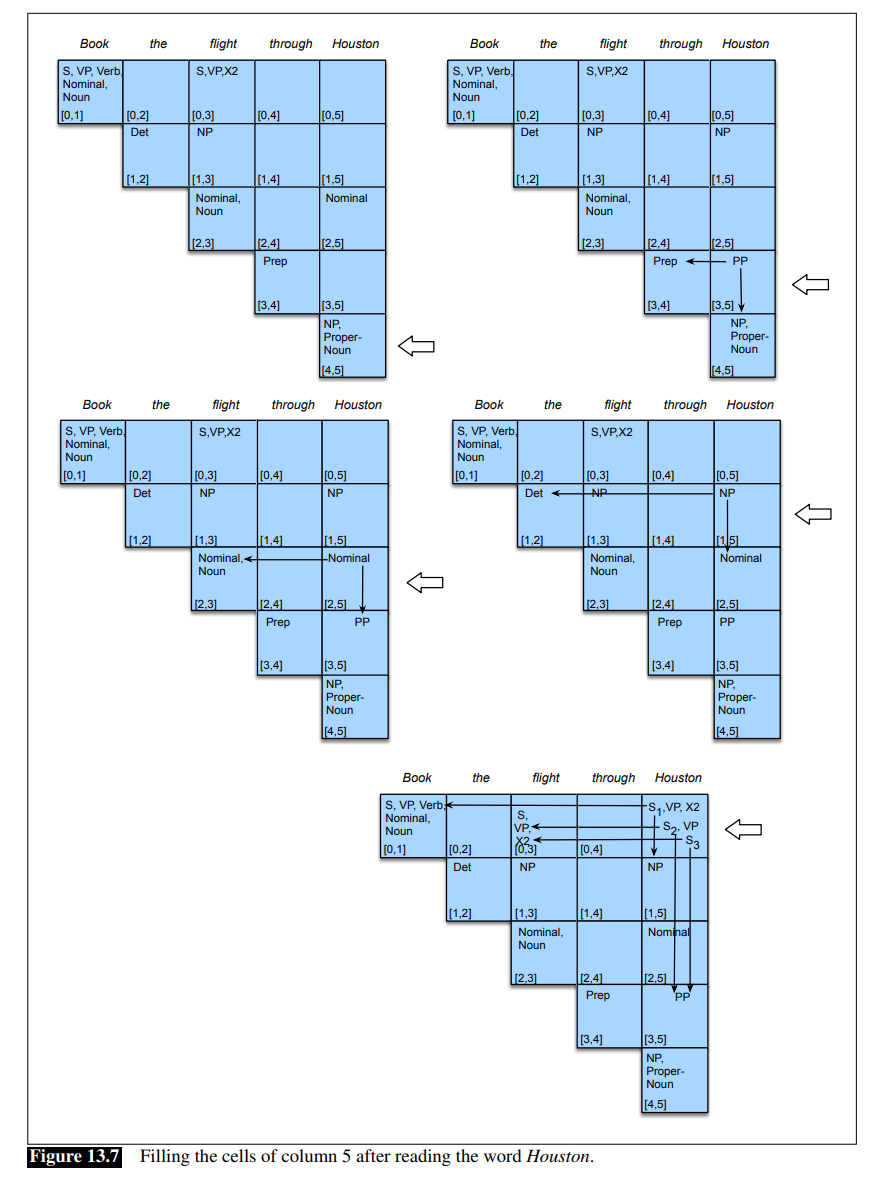

In [4]:
grammar1 = """
S -> NP VP
PP -> P NP
NP -> Det N | NP PP | N N | time
VP -> V NP | VP PP | flies
Det -> a | the | her | my | an
N -> kangaroos | pajamas | sandwiches | friends | flies | time | arrow
V -> saw | ate | like | time | flies
P -> in | like
"""

def CNF2list(CNF):
  rules = [rule.strip() for rule in CNF.strip().splitlines()]
  rules_list = []
  for rule in rules:
    left, right = rule.split(' -> ')
    list_right = right.split(' | ')
    list_right_delimited = [tuple(r.split()) for r in list_right]
    rules_list.append((left, list_right_delimited))
  return(rules_list)

print(CNF2list(grammar1))

[('S', [('NP', 'VP')]), ('PP', [('P', 'NP')]), ('NP', [('Det', 'N'), ('NP', 'PP'), ('N', 'N'), ('time',)]), ('VP', [('V', 'NP'), ('VP', 'PP'), ('flies',)]), ('Det', [('a',), ('the',), ('her',), ('my',), ('an',)]), ('N', [('kangaroos',), ('pajamas',), ('sandwiches',), ('friends',), ('flies',), ('time',), ('arrow',)]), ('V', [('saw',), ('ate',), ('like',), ('time',), ('flies',)]), ('P', [('in',), ('like',)])]


**TODO 1:** Complete the **parser** function satisfying the two modfication requirements defined above.

For your convenience, I've defined a ParserEntry class that you can use as the table entries instead of a simple string as before. Use the **print_tree** function to get visualizations of the trees, and see if you can get the following two trees for the first sentence:

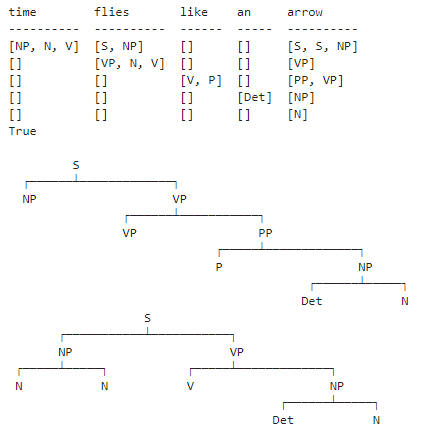

In [5]:
class ParserEntry:
    def __init__(self, label, children=None):
        self.label = label
        if children is None:
            self.children = []
        else:
            self.children = children

    def __repr__(self):
        return self.label

def pretty_print(table, sent):
    print(tabulate(table, headers=sent))

def parser(words, grammar):
    rules = CNF2list(grammar)
    n = len(words)
    table = [[[] for i in range(n)] for j in range(n)]
    
    # Fill in the base case cells (diagonal) 
    for i in range(n):
        word = words[i]
        for left, right_list in rules:
            for right in right_list:
                if len(right) == 1 and right[0] == word:
                    table[i][i].append(ParserEntry(left))

    # Fill in the rest of the table
    for length in range(2, n+1):
        for i in range(n-length+1):
            j = i + length - 1
            for k in range(i, j):
                for left, right_list in rules:
                    for right in right_list:
                        if len(right) == 2:
                            B, C = right
                            for b in table[i][k]:
                                if b.label == B:
                                    for c in table[k+1][j]:
                                        if c.label == C:
                                            table[i][j].append(ParserEntry(left, children=[b,c]))
                        elif len(right) == 1:
                            C = right[0]
                            if C in [entry.label for entry in table[i][j]]:
                                table[i][j].append(ParserEntry(left, children=[ParserEntry(C)]))
    
    recognized = any(entry.label == 'S' for entry in table[0][n-1])
    
    parses = []
    for entry in table[0][n-1]:
        if entry.label == 'S':
            parses.append(entry)
    
    return table, recognized, parses

In [6]:
sents = [
    'time flies like an arrow',
    'arrow flies like a time',
    'like time an arrow flies',
    'the kangaroos ate the sandwiches in my pajamas',
    'the kangaroos ate in my pajamas the sandwiches',
]

for sent in sents:
    table, parsed, top_right = parser(sent.split(' '), grammar1)
    pretty_print(table, sent.split())
    # True if S is in the top right cell, else False
    print(parsed)
    print()

    # Pretty printing the tree
    for entry in top_right:
        if entry.label == 'S':
            pptree.print_tree(entry, childattr='children', nameattr='label', horizontal=False)

time        flies       like    an     arrow
----------  ----------  ------  -----  ----------
[NP, N, V]  [S, NP]     []      []     [S, S, NP]
[]          [VP, N, V]  []      []     [VP]
[]          []          [V, P]  []     [PP, VP]
[]          []          []      [Det]  [NP]
[]          []          []      []     [N]
True

         S                                               
  ┌──────┴─────────────┐                                 
  NP                   VP                                
                ┌──────┴───────────┐                     
                VP                 PP                    
                             ┌─────┴─────────────┐       
                             P                   NP      
                                          ┌──────┴─────┐ 
                                         Det           N 
                   S                                 
       ┌───────────┴───────────┐                     
       NP                      VP       

## Part 2: Acceptability with language models

The following code cell will load and preprocess a subset of the Penn Treebank corpus, as we did during lab.

In [7]:
nltk.download('treebank')
sents = list(nltk.corpus.treebank.sents())
print(sents[:10])

[nltk_data] Downloading package treebank to
[nltk_data]     /usr4/ugrad/xfu/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


[['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'], ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'], ['Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.'], ['A', 'form', 'of', 'asbestos', 'once', 'used', '*', '*', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', '*', 'to', 'it', 'more', 'than', '30', 'years', 'ago', ',', 'researchers', 'reported', '0', '*T*-1', '.'], ['The', 'asbestos', 'fiber', ',', 'crocidolite', ',', 'is', 'unusually', 'resilient', 'once', 'it', 'enters', 'the', 'lungs', ',', 'with', 'even', 'brief', 'exposure

**TODO 2**: Your first task is to create a flattened corpus with \<start\> and \<end\> tokens to each sentence. Write the function **preprocess(corpus, n)** that achieves this goal. The function should add $n-1$ occurrences of \<start\> and \<end\>---for example, if you are going to get bigram statistics ($n=2$), it should append one of each, and for trigram counts, it should append two of each. It should return a list of words (i.e., "flattened"), not a list of sentences like `sents` does. Check that running the following cell produces an output like the following: 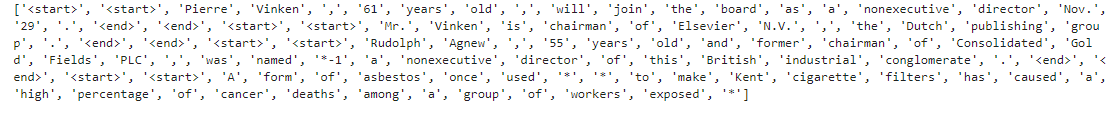

The above TODO is the same as the one you saw during lab, so you can reuse the code you wrote in Lab 4 for preprocessing the corpus.

In [8]:
def preprocess(corpus, n):
    preprocessed_corpus = []
    for sent in corpus:
        new_sent = ["<start>"]*(n-1) + sent + ["<end>"]*(n-1)
        preprocessed_corpus.append(new_sent)
    return sum(preprocessed_corpus, [])

preprocessed_corpus = preprocess(sents, 3)
print(preprocessed_corpus[:100])

['<start>', '<start>', 'Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.', '<end>', '<end>', '<start>', '<start>', 'Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.', '<end>', '<end>', '<start>', '<start>', 'Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.', '<end>', '<end>', '<start>', '<start>', 'A', 'form', 'of', 'asbestos', 'once', 'used', '*', '*', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', '*']


For this assignment, we will get our n-gram estimates from the full Brown corpus. As we discussed during the lectures, the quality of the probability estimates based on n-gram counts are highly depends on your corpus. Since the subset of the Penn Treebank corpus we used during lab is small, let's try to use a larger corpus supported by NLTK, the Brown Corpus: 

In [9]:
nltk.download('brown')
sents = list(nltk.corpus.brown.sents())
# Make sure that the first 10 sentences are different
print(sents[:10])

preprocessed_corpus = preprocess(sents, 3)
print(preprocessed_corpus[:100])

[nltk_data] Downloading package brown to /usr4/ugrad/xfu/nltk_data...
[nltk_data]   Package brown is already up-to-date!


[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'Mayor-nominate', 'Ivan', 'Allen', 'Jr.', '.'], ['``', 'Only', 'a', 'relative', 'handful', 'of', 'such', 'rep

Running preprocess will take a while because the Brown corpus is much larger!

### Part 2.1: n-gram language models

I've written the function **count_ngrams(n, corpus)** that returns a dictionary that consists of n-gram sequence:count pairs given $n$ and the preprocessed corpus.

**TODO 3.1**: Write the function **ngram_logprob(...)** that returns the n-gram **log** probability of a sentence, given the sentence in string format and two counter dictionaries (for n-gram and n-1-gram). You might find the `nltk.ngrams()` method useful. Use Laplace (add-1) smoothing.

In [10]:
def create_ngram_counter(n, corpus):
    fd = nltk.FreqDist(nltk.ngrams(corpus, n))
    return {ngram: count for ngram, count in fd.items()}

def ngram_logprob(sentence, n, ngram_counts, ngram_minus_one_counts):
    tokens = nltk.word_tokenize(sentence)
    tokens = ['<start>'] * (n-1) + tokens + ['<end>'] * (n-1)
    
    ngrams = list(nltk.ngrams(tokens, n))
    
    log_prob = 0
    
    for ngram in ngrams:
        ngram_count = ngram_counts.get(ngram, 0)
        ngram_minus_one = ngram[:-1]
        ngram_minus_one_count = ngram_minus_one_counts.get(ngram_minus_one, 0)
        
        log_prob += math.log((ngram_count + 1) / (ngram_minus_one_count + v))
    
    return log_prob

In [11]:
trigram_counter = create_ngram_counter(3, preprocessed_corpus)
bigram_counter = create_ngram_counter(2, preprocessed_corpus)
unigram_counter = create_ngram_counter(1, preprocessed_corpus)
v = len(unigram_counter)

In [12]:
v

56059

**TODO 3.2**: Show that a grammatical sentence `cigarette filters has caused a high percentage of cancer deaths` has higher log probability than an ungrammatical sentence `high filters cancer has cigarette caused deaths a of percentage` (that consists of the same words as the grammatical one), using a **trigram** model.

In [13]:
# Put two print statements that print the logprobs of the two sentences here
# I got something like -128.2 for the grammatical sentence and -131.9 for the ungrammatical sentence

grammatical_sentence = "cigarette filters has caused a high percentage of cancer deaths"
ungrammatical_sentence = "high filters cancer has cigarette caused deaths a of percentage"

grammatical_logprob = ngram_logprob(grammatical_sentence, 3, trigram_counter, bigram_counter)
ungrammatical_logprob = ngram_logprob(ungrammatical_sentence, 3, trigram_counter, bigram_counter)

print(f"Log probability of grammatical sentence: {grammatical_logprob}")
print(f"Log probability of ungrammatical sentence: {ungrammatical_logprob}")

Log probability of grammatical sentence: -128.22734937119714
Log probability of ungrammatical sentence: -131.91444554190352


Lau et al. found that the normalized log probability by division (Norm LP (Div)) correlates well with human acceptability judgments. 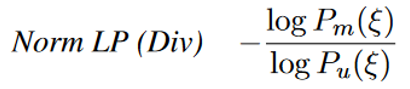

**TODO 4.1**: Implement the Norm LP (Div) measure. $\xi$ denotes the input sequence, $\log P_m$ denotes the n-gram logprob, and $\log P_u$ denotes the unigram logprob.

In [14]:
def norm_lp_div(sentence, n, ngram_counts, ngram_minus_one_counts, unigram_counts):
    tokens = nltk.word_tokenize(sentence)
    log_pm = ngram_logprob(sentence, n, ngram_counts, ngram_minus_one_counts)
    log_pu = ngram_logprob(sentence, 1, unigram_counts, {(): sum(unigram_counts.values())})
    return -(log_pm / log_pu)

**TODO 4.2**: Show that a grammatical sentence `He likes cats and dogs` has higher Norm LP (Div) measure than an ungrammatical sentence `likes dogs he cats and`, using a trigram model.

In [15]:
# Put two print statements that print the Norm LP (Div) measures for the two sentences here
# I got something like -1.61 for the grammatical sentence and -1.83 for the ungrammatical sentence

# Create trigram, bigram, and unigram count dictionaries
trigram_counts = create_ngram_counter(3, preprocessed_corpus)
bigram_counts = create_ngram_counter(2, preprocessed_corpus)
unigram_counts = create_ngram_counter(1, preprocessed_corpus)

# Define the grammatical and ungrammatical sentences
grammatical_sentence = "He likes cats and dogs"
ungrammatical_sentence = "likes dogs he cats and"

# Calculate and print the Norm LP (Div) measures for the sentences
grammatical_norm_lp_div = norm_lp_div(grammatical_sentence, 3, trigram_counts, bigram_counts, unigram_counts)
ungrammatical_norm_lp_div = norm_lp_div(ungrammatical_sentence, 3, trigram_counts, bigram_counts, unigram_counts)

print(f"Norm LP (Div) measure of the grammatical sentence: {grammatical_norm_lp_div}")
print(f"Norm LP (Div) measure of the ungrammatical sentence: {ungrammatical_norm_lp_div}")

Norm LP (Div) measure of the grammatical sentence: -1.612049308392368
Norm LP (Div) measure of the ungrammatical sentence: -1.8317341185926008


### Part 2.2: RNN language model

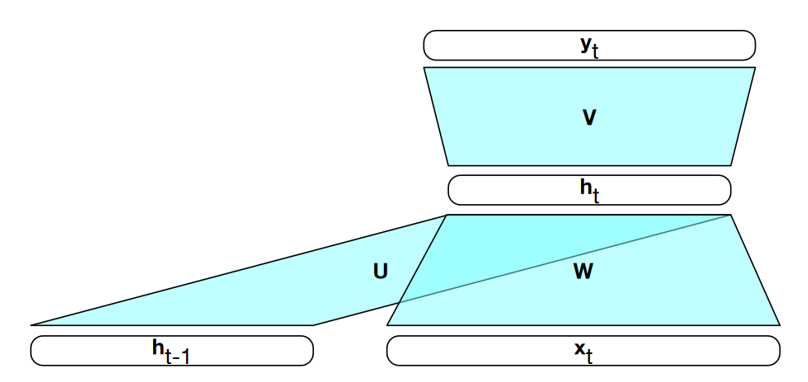

**TODO 5**: I've written most of the SRN model code already. Your job here is to complete the forward pass computation by adding code that computes `h` at for each input (i.e., for each timestep). Use `np.tanh()` as the activation function for the hidden layer, and use `softmax` for the output layer.

FYI: `@` is the matrix multiplication operator.

In [16]:
vocabulary = {word[0]:i for i, word in enumerate(unigram_counter.keys())}
print(len(vocabulary))

56059


In [23]:
def softmax(x):
    return (np.exp(x)/np.exp(x).sum())

def inputs_embed(inputs, vocabulary):
    embedded_inputs = []
    unk_idx = len(vocabulary)
    for inp in inputs:
        vec = np.zeros((len(vocabulary)+1, 1))
        one_hot_idx = vocabulary.get(inp, unk_idx)
        vec[one_hot_idx] = 1
        embedded_inputs.append(vec)
    return np.array(embedded_inputs).squeeze()

class SRN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.sigma = 1
        self.mu = 0
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W = self.sigma * np.random.randn(hidden_dim, input_dim) + self.mu
        self.U = self.sigma * np.random.randn(hidden_dim, hidden_dim) + self.mu
        self.V = self.sigma * np.random.randn(output_dim, hidden_dim) + self.mu
        
        self.b_h = np.zeros((hidden_dim, 1))
        self.b_out = np.zeros((output_dim, 1)) # Changed shape to (output_dim, 1), 56059

    def forward(self, inputs):
        h = self.sigma * np.random.randn(self.hidden_dim, 1) + self.mu  # I changed the shape to (hidden_dim, 1)
        for i in inputs:
            i = np.expand_dims(i, axis=1)
            # TODO: write code that computes h at each timestep.
            # Use np.tanh() as the activation function
            h = np.tanh(np.dot(self.W, i) + np.dot(self.U, h) + self.b_h)
        
        # TODO: write code that computes the final output
        output = np.dot(self.V, h) + self.b_out
        output = softmax(output)
        
        return output

Running the code cell below will give you something like:

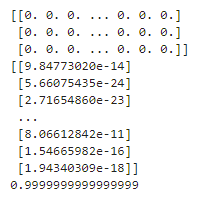

(But this is not very informative because this model isn't trained on any data. We will hopefully have time to get to this in later classes)

In [24]:
np.random.seed(100)

model = SRN(len(vocabulary)+1, 100, len(vocabulary)+1)
inputs = inputs_embed("my name is".split(), vocabulary)
print(inputs)
out = model.forward(inputs)
print(out)
print(np.sum(out))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[2.00864909e-19]
 [3.64344607e-20]
 [2.31095511e-16]
 ...
 [2.28810369e-20]
 [4.91081400e-14]
 [3.12232286e-14]]
0.9999999999999998


### Part 2.3: Applying probability computation to a dataset

So far, we've looked at applying our (log) probability computation to single sentences. What if we want to look at dataset-level trends? We will look at using the `minicons` package (https://github.com/kanishkamisra/minicons) to help us with this.

In [25]:
%pip install minicons
import os
_CACHE_DIR = '/projectnb/lx496/.cache/'
os.environ['HF_HOME'] = _CACHE_DIR

from minicons import scorer

Note: you may need to restart the kernel to use updated packages.


In [26]:
model = scorer.IncrementalLMScorer('RWKV/rwkv-4-169m-pile', 'cpu')
print(model.sequence_score(["He likes cats and dogs", "likes dogs he cats and"], reduction = lambda x: x.mean(0).item()))

sent1_acceptable = "cigarette filters has caused a high percentage of cancer deaths"
sent2_unacceptable = "high filters cancer has cigarette caused deaths a of percentage"
print(model.sequence_score([sent1_acceptable, sent2_unacceptable], reduction = lambda x: x.mean(0).item()))

[-4.619339942932129, -7.106192111968994]
[-4.071873188018799, -9.319046020507812]


The code above loads a model called RWKV (https://arxiv.org/abs/2305.13048), a variant of an RNN model. The particular model we loaded (`RWKV/rwkv-4-169m-pile`) is a RWKV model with 169M parameters trained on a large dataset called the Pile (https://huggingface.co/datasets/EleutherAI/pile) on predicting the next word as we discussed in class. And we can get the log probability estimate of a sentence from this model in the way that we discussed in class: summing the log probabilities, where each term in the sum is the conditional probability of the next word given the prefix.

The `minicons` package will do this for you: running the above code will produce the following logprob estimates:

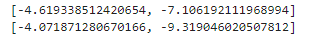

Note that we passed `mean` as the reduction parameter: this is equivalent to using the `Mean LP` method in Lau et al. 

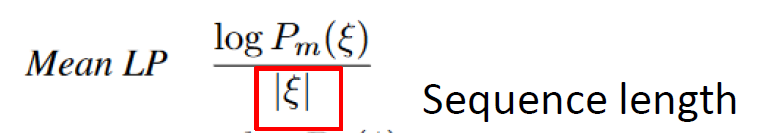

(Food for thought: why is it hard to use the Norm LP (Div) here?)

It is hard to use the Norm LP (Div) here because the minicons package does not provide a way to directly compute the unigram log probabilities needed for normalization. The package focuses on computing the log probabilities from the language model itself, which is trained on sequences of words rather than individual words. To use Norm LP (Div), we would need to separately compute the unigram probabilities from a different source or model.

### Loading the Warstadt et al. (2019) acceptability data

Let's try using the Mean LP estimates from the RNN model to see if it can capture the acceptable vs. unacceptable judgments from Warstadt et al.'s data collected from Linguistics textbooks. I've downloaded the dataset and specified the path to `_COLA_DATASET_PATH`.

**TODO 6.1**: Write code to read the dataset and append acceptable sentences to `acceptable_sents` and unacceptable sentences to `unacceptable_sents`. You can find information about what each field in the dataset means in this website: https://nyu-mll.github.io/CoLA/ under the `Data Format` section.

In [27]:
_COLA_DATASET_PATH = "/projectnb/lx496/shared/cola_public/tokenized/in_domain_dev.tsv"
acceptable_sents = []
unacceptable_sents = []

# TODO: Read the dataset and append acceptable sentences to `acceptable_sents` and unacceptable sentences to `unacceptable_sents`.

with open(_COLA_DATASET_PATH, 'r') as file:
    for line in file:
        fields = line.strip().split('\t')
        label = int(fields[1])
        sentence = fields[3]
        
        if label == 1:
            acceptable_sents.append(sentence)
        elif label == 0:
            unacceptable_sents.append(sentence)

**TODO 6.2**: Write code that computes the average Mean LP of all acceptable sentences and all unacceptable sentences in the dataset estimated **from the RWKV model**, and verify that the first value is larger than the second value. 

These are the values I got:
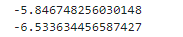

In [28]:
acceptable_normalized_logprobs = model.sequence_score(acceptable_sents, reduction=lambda x: x.mean(0))
unacceptable_normalized_logprobs = model.sequence_score(unacceptable_sents, reduction=lambda x: x.mean(0))
print(np.mean(acceptable_normalized_logprobs))
print(np.mean(unacceptable_normalized_logprobs))

-5.8467484
-6.533634


**TODO 6.3**: Write code that computes the **Norm LP (Div)** measure of all acceptable sentences and all unacceptable sentences in the dataset estimated **from the trigram model**, and verify that the first value is larger than the second value.

These are the values I got:
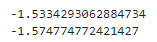

In [29]:
acceptable_score_trigram = [norm_lp_div(sent, 3, trigram_counter, bigram_counter, unigram_counter) for sent in acceptable_sents]
unacceptable_score_trigram = [norm_lp_div(sent, 3, trigram_counter, bigram_counter, unigram_counter) for sent in unacceptable_sents]

print(np.mean(acceptable_score_trigram))
print(np.mean(unacceptable_score_trigram))

-1.5334293062884734
-1.574774772421427
